In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())
main_dir = os.environ.get("MAIN_DIRECTORY")
os.chdir(main_dir)

np.random.seed(0)

from preprocessing.preprocessor import preprocess_text

from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional


In [2]:
model_save_path = os.environ.get("PRETRAINED_MODELS_PATH")

In [3]:
data = pd.read_csv('models/text_model/data/text_data.csv')
data.head()

,Sentiment,Text_ID,Datetime,Query,Username,Text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
data.shape

(1600000, 6)

In [5]:
data.columns

Index(['Sentiment', 'Text_ID', 'Datetime', 'Query', 'Username', 'Text'], dtype='object')

In [6]:
# Dropping unnecessary columns
new_data = data.drop(["Text_ID", "Datetime", "Query", "Username"], axis=1)
new_data.head()

,Sentiment,Text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [7]:
# Number of values of each sentiment
new_data["Sentiment"].value_counts()

Sentiment
0    800000
4    800000
Name: count, dtype: int64

In [8]:
new_data["Sentiment"] = new_data["Sentiment"].apply(lambda x: 1 if x==4 else 0)

In [9]:
new_data["Sentiment"].value_counts()

Sentiment
0    800000
1    800000
Name: count, dtype: int64

In [10]:
new_data["Text"] = new_data["Text"].apply(preprocess_text)

In [11]:
new_data.head()

,Sentiment,Text
0,0,awww thats bummer shoulda got david carr third...
1,0,upset cant update facebook texting mi guessht ...
2,0,dived many times ball managed save 50 rest go ...
3,0,whole body feels itchy like fire
4,0,behaving im mad cant see


In [12]:
negative_text = new_data[new_data["Sentiment"] == 0]
positive_text = new_data[new_data["Sentiment"] == 1]

In [13]:
randn_idx = list(np.random.randint(0, 800000 + 1, size=50000))

In [14]:
negative_text = negative_text.iloc[randn_idx]
positive_text = positive_text.iloc[randn_idx]

final_data = pd.concat([negative_text, positive_text])

In [15]:
def generate_wordcloud(df):

    text = " ".join(df["Text"])

    wordcloud = WordCloud(width=800, height=400).generate(text)

    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

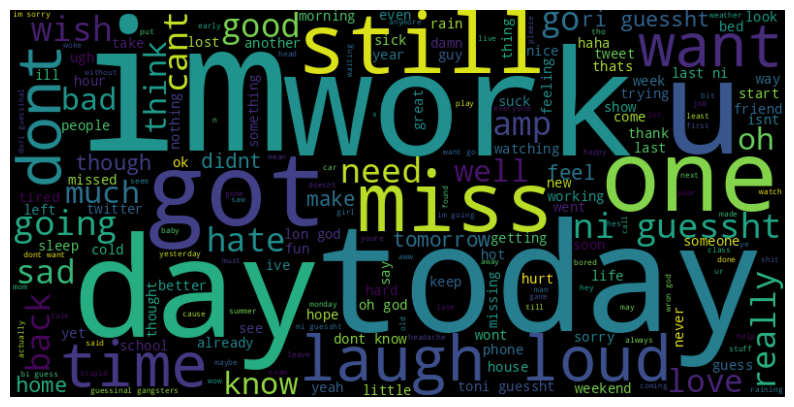

In [16]:
generate_wordcloud(negative_text[:25000])

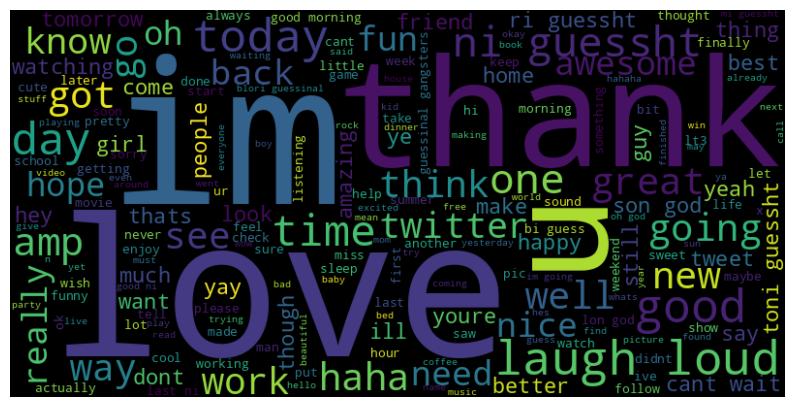

In [17]:
generate_wordcloud(positive_text[:25000])

In [18]:
tokenizer = Tokenizer(num_words=1000, oov_token="<OOV>")
tokenizer.fit_on_texts(final_data["Text"])

In [19]:
sequences = tokenizer.texts_to_sequences(final_data["Text"])
X = pad_sequences(sequences, maxlen=25, padding='post')
y = pd.get_dummies(final_data["Sentiment"], drop_first=True)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [21]:
model = Sequential()
model.add(Embedding(input_dim=1000, output_dim=64, input_length=25))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation="sigmoid"))

In [22]:
opt = keras.optimizers.legacy.RMSprop(learning_rate=0.005)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 64)            64000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 130,177
Trainable params: 130,177
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32)

Epoch 1/5
2500/2500 [==============================] - 128s 47ms/step - loss: 0.5366 - accuracy: 0.7274 - val_loss: 0.5068 - val_accuracy: 0.7466
Epoch 2/5
2500/2500 [==============================] - 63s 25ms/step - loss: 0.5091 - accuracy: 0.7474 - val_loss: 0.5082 - val_accuracy: 0.7483
Epoch 3/5
2500/2500 [==============================] - 114s 46ms/step - loss: 0.5025 - accuracy: 0.7525 - val_loss: 0.5072 - val_accuracy: 0.7472
Epoch 4/5
2500/2500 [==============================] - 126s 50ms/step - loss: 0.4994 - accuracy: 0.7544 - val_loss: 0.5080 - val_accuracy: 0.7504
Epoch 5/5
2500/2500 [==============================] - 133s 53ms/step - loss: 0.4964 - accuracy: 0.7567 - val_loss: 0.5068 - val_accuracy: 0.7495


In [25]:
sentence = "i am very happy"
sentence = [sentence]
sequence = tokenizer.texts_to_sequences(sentence)
text = pad_sequences(sequence, maxlen=25, padding='post')

pred = model.predict(text, verbose=0)

if pred[0][0] > 0.5:
    print("Emotion is positive")
    print(pred[0][0])
else:
    print("Emotion is negative")
    print(pred[0][0])

Emotion is positive
0.804429


In [26]:
loss, accuracy = model.evaluate(X_test, y_test)

625/625 [==============================] - 6s 10ms/step - loss: 0.5068 - accuracy: 0.7495


In [27]:
model_json = model.to_json()
with open(f"{model_save_path}/text_model.json", "w") as json_file:
    json_file.write(model_json)